## Comprehensive circuit

In [1]:
using NeuroPALData, DelimitedFiles, ANTSUNData, HDF5, JSON, PyPlot,
    PyCall, Statistics, Combinatorics, LinearAlgebra, FlavellBase, NaNMath,
    Distances, StatsBase, Random, Suppressor, LinearAlgebra, ProgressMeter,
    FlavellConstants, EncoderModelGen, HypothesisTests,
    CePNEMAnalysis, YAML, Clustering, JLD2, Distributions, MultipleTesting,
    KernelDensity, ConnectomePlot, Colors, HierarchicalPosteriorModel, GLM, DataFrames
zstd = FlavellBase.standardize

rc_params = PyDict(pyimport("matplotlib")["rcParams"]);
rc_params["font.sans-serif"] = ["Arial"];
rc_params["font.size"] = 7;
fix_plot() = (margins(0.05); tick_params(direction = "out");
    ax = gca(); ax[:xaxis][:tick_bottom]();
    ax[:yaxis][:tick_left]();
    ax[:spines]["top"]["set_visible"](false);
    ax[:spines]["right"]["set_visible"](false););

WebIO._IJuliaInit()

In [2]:
path_fig_root = "/data1/prj_kfc/figure/manuscript/cell_draft2/figure4/hc_circuit/"
mkpath(path_fig_root)

"/data1/prj_kfc/figure/manuscript/cell_draft2/figure4/hc_circuit"

In [3]:
py_scipy = pyimport("scipy")
py_nx = pyimport("networkx")
py_copy = pyimport("copy");

In [4]:
θh_pos_is_ventral = YAML.load_file("/data1/prj_kfc/data/data_constant/pos_is_ventral.yaml");

## Data

### Load data

In [5]:
list_uid_baseline = sort(["2022-06-14-01", "2022-06-14-07",
    "2022-06-14-13", "2022-06-28-01", "2022-06-28-07",
    "2022-07-15-06", "2022-07-15-12",
    "2022-07-20-01", "2022-07-26-01", "2022-08-02-01",
    "2023-01-09-28", "2023-01-17-01", "2023-01-19-01",
    "2023-01-19-08", "2023-01-19-15", "2023-01-19-22",
    "2023-01-23-01", "2023-01-23-08", "2023-01-23-15", "2023-01-23-21",
    "2023-03-07-01"])

list_uid_heat = ["2022-12-21-06", "2023-01-05-01", "2023-01-05-18",
    "2023-01-06-01", "2023-01-06-08", "2023-01-06-15", "2023-01-09-08",
    "2023-01-09-15", "2023-01-09-22", "2023-01-10-07", "2023-01-10-14",
    "2023-01-13-07", "2023-01-16-01", "2023-01-16-08", "2023-01-16-15",
    "2023-01-16-22", "2023-01-17-07", "2023-01-17-14", "2023-01-18-01"] |> sort;
# short: "2022-05-17-01", "2022-05-17-06"

In [6]:
list_uid = vcat(list_uid_baseline, list_uid_heat); length(list_uid)

40

In [7]:
list_data_dict = []
@showprogress for (idx_uid, data_uid) = enumerate(list_uid)
    path_data = "/scratch/prj_kfc/processed_h5/$(data_uid)-data.h5"
    data_dict = import_data(path_data, custom_keys=["neuropal_registration"])

    push!(list_data_dict, data_dict)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


### Load NeuroPAL

In [8]:
list_neuropal_label = load("/scratch/prj_kfc/list_neuropal_label.jld2")["list_neuropal_label"];

In [9]:
# path_h5_enc = "/data1/prj_kfc/data/gen_analysis_data/2022-10-14-neuropal-enc.h5"
path_h5_enc = "/scratch/prj_kfc/2023-03-31-neuropal-baseline-enc.h5"
path_h5_enc_heat = "/scratch/prj_kfc/2023-03-07-neuropal-heatstim-enc.h5"
list_dict_fit = []

@showprogress for uid = list_uid
    if uid in list_uid_baseline
        push!(list_dict_fit, h5read(path_h5_enc, uid))
    elseif uid in list_uid_heat
        push!(list_dict_fit, h5read(path_h5_enc_heat, uid))        
    else
        error("$uid does not exist")
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


In [10]:
list_neuropal_order_info = readdlm("/data1/prj_neuropal/data/neuropal_label_prj_kfc/NeuroPAL order LR.csv",',');

In [11]:
list_class_dv = get_list_class_dv(map(x->x[1],list_neuropal_label));

In [12]:
list_class_ordered = generate_list_class_custom_order(list_neuropal_order_info, list_class_dv);

┌ Warning: class ASE is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class IL1 is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class IL2 is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class RMH is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class SAAD is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class SABV is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100


In [13]:
list_class_classify_dv_enc = ["SIA","SMB"] # classify based on D/V tuning

2-element Vector{String}:
 "SIA"
 "SMB"

In [14]:
list_match_dict = get_list_match_dict(list_neuropal_label, list_data_dict=list_data_dict, list_dict_fit=list_dict_fit,
    list_class_ordered=list_class_ordered,
    list_class_classify_dv_enc=list_class_classify_dv_enc, θ_confidence_label=2.5);

In [15]:
list_uid_no_pumping = h5read(path_h5_enc, "list_uid_invalid_pt")
list_uid_pumping = setdiff(list_uid, list_uid_no_pumping)
list_idx_uid_pumping = [idx_uid for idx_uid = 1:length(list_uid) if list_uid[idx_uid] in list_uid_pumping];

In [16]:
list_class_dv_ordered = let
    list_all_class = unique(vcat(map(x->collect(keys(x[2])), list_match_dict)...))
    list_intersect = intersect(map(x->x[2], list_class_ordered), list_all_class)
    println("missing (in the ordering file but not in the matches): ", setdiff(setdiff(map(x->x[2], list_class_ordered), list_all_class)))
    println("n(class): $(length(list_intersect))")
    list_intersect
end;

missing (in the ordering file but not in the matches): Any["AVG", "RIG", "DB02", "DD01", "VB01", "ADF"]
n(class): 97


In [17]:
function get_list_use_rg_t(list_uid, list_uid_heat, list_dict_fit; θ_pumping=0.5)
    list_all = Tuple{String,Vector{Int}}[]
    list_pumping = Tuple{String,Vector{Int}}[]
    
    for (i_uid, uid) = enumerate(list_uid)
        lattice_range_p = list_dict_fit[i_uid]["lattice_range"]["P"]
        
        q_heat = uid in list_uid_heat
        rg_t = q_heat ? Int[1] : 1:length(lattice_range_p)
        
        list_rg_t_all = Int[]
        list_rg_t_pumping = Int[]
        
        for i_rg_t = rg_t
            # check pumping variance
            lattice_p = lattice_range_p["$i_rg_t"]
            if abs(lattice_p[2] - lattice_p[1]) .> θ_pumping
                push!(list_rg_t_pumping, i_rg_t)
            end
            
            push!(list_rg_t_all, i_rg_t)
        end
        
        push!(list_all, (uid, list_rg_t_all))
        push!(list_pumping, (uid, list_rg_t_pumping))
    end
    
    list_all, list_pumping
end

list_uid_use_all, list_uid_use_pumping = get_list_use_rg_t(list_uid, list_uid_heat, list_dict_fit);

## Connectome

### Connectome - White et al L/R

In [18]:
g_wh_lr = get_graph_white(0)
ensory_wh_lr, list_muscle_wh_lr = get_sensory_muscle(g_wh_lr);

In [19]:
g_wh_lr_p = get_graph_white_p(0)
list_sensory_wh_lr_p, list_muscle_wh_lr_p = get_sensory_muscle(g_wh_lr_p);

In [20]:
g_wv = get_graph_witvliet(2, merge_lr=true)
# list_sensory_wv, list_muscle_wv = get_sensory_muscle(g_wv);

g_wv_lr = get_graph_witvliet(2);
# list_sensory_wv_lr, list_muscle_wv_lr = get_sensory_muscle(g_wv_lr);

In [21]:
dict_pos_z_non_p = Base.ImmutableDict(ConnectomePlot.dict_pos_z_non_p...)
dict_pos_v2_non_p = Base.ImmutableDict(ConnectomePlot.dict_pos_v2_non_p...)
dict_pos_v3_non_p = Base.ImmutableDict(ConnectomePlot.dict_pos_v3_non_p...)

dict_pos_z_p = Base.ImmutableDict(ConnectomePlot.dict_pos_z_p...)
dict_pos_v2_p = Base.ImmutableDict(ConnectomePlot.dict_pos_v2_p...)
dict_pos_v3_p = Base.ImmutableDict(ConnectomePlot.dict_pos_v3_p...)

dict_pos_v2_patch, dict_pos_z_patch = get_dict_pos_patched();

### HB model fit

In [22]:
function shuffle_dict_feature(dict_feature)
    shuffled = typeof(dict_feature)()
    
    ks = collect(keys(dict_feature))
    ks_shuffled = shuffle(ks)
    
    for (k,k_new) = zip(ks, ks_shuffled)
        shuffled[k_new] = dict_feature[k]
    end
    
    shuffled
end

shuffle_dict_feature (generic function with 1 method)

In [23]:
extrapolated_behaviors = load("/data1/prj_neuropal/data/extrapolated_behaviors.jld2")["extrapolated_behaviors"];
eb_n_t = size(extrapolated_behaviors,1)
eb_list_b = [extrapolated_behaviors[:,i] for i = 1:3];
hb_model_result = load("/data1/prj_neuropal/data/hierarchical_dict.jld2")["hierarchical_dict"]
hb_model_rel_enc = load("/data1/prj_neuropal/data/hierarchical_relative_encoding_strength.jld2")["hierarchical_relative_encoding_strength"];

In [24]:
dict_ps = hb_model_result["hierarchical_model_params"]
dict_distribution = Dict{String,Dict{String,Vector{Float64}}}()
for (class, dict_ps) = dict_ps
    ps_mu = dict_ps.mu
    ps_sigma = dict_ps.sigma

    ps_mu = vcat(ps_mu[1], exp(ps_mu[2]), ps_mu[3:end])
    ps_sigma = exp.(ps_sigma)

    dict_distribution[class] = Dict("mu"=>ps_mu, "sigma"=>ps_sigma)
end

In [25]:
hb_tuning = load("/data1/prj_neuropal/data/hierarchical_tunings_zstd.jld2")["hierarchical_tunings"];

## Plot

In [26]:
default_node_size = 400
n_min_synapse_chemical = 1
n_min_synapse_electrical = 1

1

### nodes

In [27]:
dict_neuron_instance = Dict{String,Any}()
let
    for neuron = ["RMED", "RMEV", "RMEL", "RMER", "RMDVL", "RMDVR", "RMDDL", "RMDDR", "RMDL", "RMD",
            "SMDVL", "SMDVR", "SMDDL", "SMDDR", "SMBVL", "SMBVR", "SMBDL", "SMBDR", "SAAVL", "SAAVR", "SAADL", "SAADR"]
        dict_neuron_instance[neuron] = [neuron]
    end 
    
    for i = 3:7
        for neuron = ["BWM-DL0$i", "BWM-DR0$i", "BWM-VL0$i", "BWM-VR0$i"]
            dict_neuron_instance[neuron] = [neuron]
        end
    end

    # for class = ["AIN", "RIH", "URY", "IL1", "OLQ", "RIP",
    #     "RIC", "ADA", "AIA", "AIM", "AUA", "RIB", "RID", "AVB", "AIB", "RIM", "AVE", "AVA",
    #         "AIY", "AVK", "AVL","RIV", "RIS",
    #         "I1","I2","I3","I4","I5","I6","NSM","M1","M3","M4","M5","MC","MI"]
    
    for class = ["OLQ","OLL","IL1","RIH","CEP","URX","URB",
            "RIP",
        "RIC", "ADA", "AIA", "AIM", "AUA", "RIB", "RID", "AVB", "AIB", "RIM", "AVE", "AVA",
            "AIY", "AVK", "AVL","RIV",
            "I1","I2","I3","I4","I5","I6","NSM","M1","M3","M4","M5","MC","MI"]
        list_ = []
            for (k,v) = NeuroPALData.NEURON_REF_DICT
                if v["class"] == class
                    push!(list_, k)#(k, v["class"], v["LR"]))
                end
            end
        dict_neuron_instance[class] = list_
    end
end

In [28]:
dict_node = Dict{String,Dict}()
id_to_node_label = Dict{Int,String}()
node_label_to_id = Dict{String,Int}()

dict_node["RMED"] = Dict("pos"=>(2,0), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["RMEV"] = Dict("pos"=>(-2,0), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["RMEL"] = Dict("pos"=>(0,-4), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["RMER"] = Dict("pos"=>(0,4), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")

dict_node["RMDVL"] = Dict("pos"=>(4,-4), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["RMDVR"] = Dict("pos"=>(4, 4), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["RMDDL"] = Dict("pos"=>(-4,-4), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["RMDDR"] = Dict("pos"=>(-4, 4), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["RMDL"] = Dict("pos"=>(0, -2), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["RMDR"] = Dict("pos"=>(0, 2), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")

dict_node["SMDVL"] = Dict("pos"=>(5.25, -2), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["SMDVR"] = Dict("pos"=>(5.25, 2), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["SMDDL"] = Dict("pos"=>(-5.25, -2), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["SMDDR"] = Dict("pos"=>(-5.25, 2), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")

dict_node["SMBVL"] = Dict("pos"=>(6.5, -4), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["SMBVR"] = Dict("pos"=>(6.5, 4), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["SMBDL"] = Dict("pos"=>(-6.5, -4), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["SMBDR"] = Dict("pos"=>(-6.5, 4), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")

dict_node["SAAVL"] = Dict("pos"=>(5.25, -6), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["SAAVR"] = Dict("pos"=>(5.25, 6), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["SAADL"] = Dict("pos"=>(-5.25, -6), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")
dict_node["SAADR"] = Dict("pos"=>(-5.25, 6), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"head")

for i = 3:7
    dict_node["BWM-DL0$i"] = Dict("pos"=>(-9, -2.), "size"=>default_node_size, "node_type"=>"muscle", "node_subtype"=>"none")
    dict_node["BWM-DR0$i"] = Dict("pos"=>(-9, 2.), "size"=>default_node_size, "node_type"=>"muscle", "node_subtype"=>"none")
    dict_node["BWM-VL0$i"] = Dict("pos"=>(9, -2.), "size"=>default_node_size, "node_type"=>"muscle", "node_subtype"=>"none")
    dict_node["BWM-VR0$i"] = Dict("pos"=>(9, 2.), "size"=>default_node_size, "node_type"=>"muscle", "node_subtype"=>"none")
end

dict_node["BWM-DL"] = Dict("pos"=>(-9, -2.), "size"=>default_node_size, "node_type"=>"muscle_group", "node_subtype"=>"none")
dict_node["BWM-DR"] = Dict("pos"=>(-9, 2.), "size"=>default_node_size, "node_type"=>"muscle_group", "node_subtype"=>"none")
dict_node["BWM-VL"] = Dict("pos"=>(9, -2.), "size"=>default_node_size, "node_type"=>"muscle_group", "node_subtype"=>"none")
dict_node["BWM-VR"] = Dict("pos"=>(9, 2.), "size"=>default_node_size, "node_type"=>"muscle_group", "node_subtype"=>"none")

#### middle
#    ["OLQ","OLL","IL1","RIH","CEP","URX"]
dict_node["CEP"] = Dict("pos"=>(-3,-10), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"middle")
dict_node["RIH"] = Dict("pos"=>(0,-10), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"middle")
dict_node["URX"] = Dict("pos"=>(-2,-12), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"middle")
dict_node["OLL"] = Dict("pos"=>(-5,-13), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"middle")
dict_node["OLQ"] = Dict("pos"=>(2.7,-12), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"middle")
dict_node["IL1"] = Dict("pos"=>(-7,-10), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"middle")
dict_node["URB"] = Dict("pos"=>(-9,-13), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"middle")

# dict_node["AIN"] = Dict("pos"=>(-3,-10), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"middle")
# dict_node["RIH"] = Dict("pos"=>(0,-10), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"middle")
# dict_node["URY"] = Dict("pos"=>(-2,-12), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"middle")
# dict_node["RIS"] = Dict("pos"=>(-5,-13), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"middle")
# dict_node["OLQ"] = Dict("pos"=>(2.7,-12), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"middle")
# dict_node["IL1"] = Dict("pos"=>(-7,-10), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"middle")

dict_node["RIP"] = Dict("pos"=>(0.5,-15.8), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"middle")


#### locomotion
Δx_loc, Δy_loc = -5, -18
    # gr
dict_node["RIC"] = Dict("pos"=>(-2+Δx_loc,1.25+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")
dict_node["ADA"] = Dict("pos"=>(2+Δx_loc,0.8+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")
# dict_node["AIY"] = Dict("pos"=>(0,0), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")

# FWD
dict_node["AIY"] = Dict("pos"=>(-5+Δx_loc,-4+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")
dict_node["AIA"] = Dict("pos"=>(-3+Δx_loc,-2+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")
dict_node["AIM"] = Dict("pos"=>(-2.5+Δx_loc,-4.5+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")
dict_node["AUA"] = Dict("pos"=>(-4.3+Δx_loc,-6+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")
dict_node["RIB"] = Dict("pos"=>(-1.8+Δx_loc,-8+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")
dict_node["RID"] = Dict("pos"=>(-3+Δx_loc,-10.1+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")
dict_node["AVB"] = Dict("pos"=>(-1.7+Δx_loc,-12+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")
dict_node["AVK"] = Dict("pos"=>(-3+Δx_loc,-14+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")

# REV
dict_node["AIB"] = Dict("pos"=>(3+Δx_loc,-2+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")
dict_node["RIM"] = Dict("pos"=>(1.7+Δx_loc,-5+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")
dict_node["AVE"] = Dict("pos"=>(3+Δx_loc,-7+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")
dict_node["AVA"] = Dict("pos"=>(1.5+Δx_loc,-11+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")
dict_node["RIV"] = Dict("pos"=>(3+Δx_loc,-9+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")
dict_node["AVL"] = Dict("pos"=>(2.5+Δx_loc,-13.5+Δy_loc), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"locomotion")

#### feeding
Δx_p, Δy_p = 5, -20
dict_node["I1"] = Dict("pos"=>(-2+Δx_p, Δy_p), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"pharyngeal")
dict_node["I2"] = Dict("pos"=>(-4+Δx_p, -2+Δy_p), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"pharyngeal")
dict_node["I3"] = Dict("pos"=>(-1.5+Δx_p, -2.25+Δy_p), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"pharyngeal")
dict_node["I4"] = Dict("pos"=>(-4+Δx_p, -4.5+Δy_p), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"pharyngeal")
dict_node["I5"] = Dict("pos"=>(-0.5+Δx_p, -5+Δy_p), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"pharyngeal")
dict_node["I6"] = Dict("pos"=>(-2+Δx_p, -6.5+Δy_p), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"pharyngeal")
dict_node["NSM"] = Dict("pos"=>(Δx_p, 1.5+Δy_p), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"pharyngeal")
dict_node["M1"] = Dict("pos"=>(2+Δx_p, 0.25+Δy_p), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"pharyngeal")
dict_node["M3"] = Dict("pos"=>(0.5+Δx_p, -2+Δy_p), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"pharyngeal")
dict_node["M4"] = Dict("pos"=>(3.25+Δx_p, -2.25+Δy_p), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"pharyngeal")
dict_node["M5"] = Dict("pos"=>(2+Δx_p, -4+Δy_p), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"pharyngeal")
dict_node["MC"] = Dict("pos"=>(1+Δx_p, -7+Δy_p), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"pharyngeal")
dict_node["MI"] = Dict("pos"=>(3+Δx_p, -6+Δy_p), "size"=>default_node_size, "node_type"=>"neuron", "node_subtype"=>"pharyngeal")

let
    i_node = 1
    for (k,v) = dict_node
        id_to_node_label[i_node] = k
        v["id"] = i_node
        
        node_label_to_id[k] = i_node
        
        i_node += 1
    end
end

### edges

In [29]:
list_synapses_np = let
    data_connectome1 = ConnectomePlot.data_connectome_witvliet_7
    data_connectome2 = ConnectomePlot.data_connectome_witvliet_8
    
    list_neuron = sort(collect(keys(dict_neuron_instance)))
    list_synapses = Tuple{Int,Int,String,Int}[]
    for class_presynaptic = list_neuron, class_postsynaptic = list_neuron
        n_synapse_electrical = 0
        n_synapse_chemical = 0
        
        for presynaptic = dict_neuron_instance[class_presynaptic], postsynaptic = dict_neuron_instance[class_postsynaptic]
            for data = [data_connectome1, data_connectome2]
                list_edges = filter(x->x["pre"] == presynaptic && x["post"] == postsynaptic, data)
                if length(list_edges) > 0
                    for edge = list_edges
                        edge_type = edge["typ"] == 0 ? "chemical" : "electrical"
                        #0: chemical synapse 2: electrical synapse (gap junction)
                        edge_count = sum(edge["syn"])

                        if edge_type == "chemical"
                            n_synapse_chemical += edge_count
                        else
                            n_synapse_electrical += edge_count
                        end
                    end # edge list
                end # if length(list_edges)
            end # data
            if n_synapse_chemical >= n_min_synapse_chemical
                push!(list_synapses, (node_label_to_id[class_presynaptic],
                        node_label_to_id[class_postsynaptic], "chemical", n_synapse_chemical))
            end
            if n_synapse_electrical >= n_min_synapse_electrical
                push!(list_synapses, (node_label_to_id[class_presynaptic],
                        node_label_to_id[class_postsynaptic], "electrical", n_synapse_electrical))
            end
        end
    end # neuron
    
    list_synapses
end;

In [30]:
list_synapses_np # (pre, post, type, # synapses)

1707-element Vector{Tuple{Int64, Int64, String, Int64}}:
 (12, 12, "electrical", 1)
 (12, 12, "electrical", 2)
 (12, 12, "electrical", 2)
 (12, 67, "chemical", 2)
 (12, 67, "chemical", 2)
 (12, 67, "chemical", 2)
 (12, 38, "chemical", 2)
 (12, 38, "chemical", 3)
 (12, 38, "chemical", 5)
 (12, 38, "chemical", 6)
 (12, 31, "chemical", 1)
 (12, 31, "chemical", 4)
 (12, 31, "chemical", 7)
 ⋮
 (70, 66, "electrical", 1)
 (70, 66, "electrical", 1)
 (70, 49, "chemical", 1)
 (70, 49, "chemical", 1)
 (70, 69, "chemical", 1)
 (70, 69, "electrical", 1)
 (70, 69, "chemical", 1)
 (70, 69, "electrical", 1)
 (70, 69, "chemical", 1)
 (70, 69, "electrical", 1)
 (70, 69, "chemical", 1)
 (70, 69, "electrical", 2)

In [31]:
list_synapses_p = let
    data_connectome_white = ConnectomePlot.data_connectome_white
    
    # list_neuron = sort(collect(keys(dict_node)))
    list_neuron = ["I1","I2","I3","I4","I5","I6","NSM","M1","M3","M4","M5","MC","MI","RIP"]
    list_synapses = Tuple{Int,Int,String,Int}[]
    for class_presynaptic = list_neuron, class_postsynaptic = list_neuron
        n_synapse_electrical = 0
        n_synapse_chemical = 0
        
        for presynaptic = dict_neuron_instance[class_presynaptic], postsynaptic = dict_neuron_instance[class_postsynaptic]
            for data = [data_connectome_white]
                list_edges = filter(x->x["pre"] == presynaptic && x["post"] == postsynaptic, data)
                if length(list_edges) > 0
                    for edge = list_edges
                        edge_type = edge["typ"] == 0 ? "chemical" : "electrical"
                        #0: chemical synapse 2: electrical synapse (gap junction)
                        edge_count = sum(edge["syn"])

                        if edge_type == "chemical"
                            n_synapse_chemical += edge_count
                        else
                            n_synapse_electrical += edge_count
                        end
                    end # edge list
                end # if length(list_edges)
            end # data
            if n_synapse_chemical >= n_min_synapse_chemical
                push!(list_synapses, (node_label_to_id[class_presynaptic],
                        node_label_to_id[class_postsynaptic], "chemical", 2 * n_synapse_chemical))
            end
            if n_synapse_electrical >= n_min_synapse_electrical
                push!(list_synapses, (node_label_to_id[class_presynaptic],
                        node_label_to_id[class_postsynaptic], "electrical", 2 * n_synapse_electrical))
            end
        end
    end # neuron
    
    list_synapses
end;

In [32]:
list_synapses = vcat(list_synapses_np, list_synapses_p)
list_synapses = filter(x->x[1]!=x[2], list_synapses)

1680-element Vector{Tuple{Int64, Int64, String, Int64}}:
 (12, 67, "chemical", 2)
 (12, 67, "chemical", 2)
 (12, 67, "chemical", 2)
 (12, 38, "chemical", 2)
 (12, 38, "chemical", 3)
 (12, 38, "chemical", 5)
 (12, 38, "chemical", 6)
 (12, 31, "chemical", 1)
 (12, 31, "chemical", 4)
 (12, 31, "chemical", 7)
 (12, 31, "chemical", 9)
 (12, 32, "chemical", 13)
 (12, 32, "chemical", 36)
 ⋮
 (54, 15, "chemical", 2)
 (54, 15, "electrical", 2)
 (54, 45, "chemical", 2)
 (54, 45, "electrical", 2)
 (54, 45, "chemical", 4)
 (54, 45, "electrical", 4)
 (54, 48, "electrical", 4)
 (54, 48, "electrical", 8)
 (59, 60, "electrical", 2)
 (59, 60, "electrical", 2)
 (59, 60, "electrical", 2)
 (59, 60, "electrical", 4)

In [33]:
list_neuron_head_manifest = [
      ("RMD","L"),
        ("RMD","R"),
        ("RMDV","L"),
        ("RMDV","R"),
        ("RMDD","L"),
        ("RMDD","R"),
        ("RME","L"),
        ("RME","R"),
        ("RMED",nothing),
        ("RMEV",nothing),
        ("SMDV","L"),
        ("SMDV","R"),
        ("SMDD","L"),
        ("SMDD","R"),
        ("SMBD","L"),
        ("SMBD","R"),
        ("SMBV","L"),
        ("SMBV","R"),
        
        ("SAADL",nothing), # already split in match dict
        ("SAADR",nothing), # already split in match dict
        ("SAAV","L"),
        ("SAAV","R")
];

### feature compute

#### hc circuit

In [34]:
dict_dorsal_fwd, dict_dorsal_rev, dict_fwd, dict_rev = let
    enc_dor_fwd = Dict()
    enc_dor_rev = Dict()
    enc_fwd = Dict()
    enc_rev = Dict()

    for (idx_uid, (uid, rg_t)) = enumerate(list_uid_use_all)
        dict_fit = list_dict_fit[idx_uid]
        dict_match = list_match_dict[idx_uid][2]
        
        for rg_t = rg_t
            dict_ts = dict_fit["tuning_strength"]["$rg_t"]
            for (idx_class, (class_dv, class_lr)) = enumerate(list_neuron_head_manifest)
                neuron_match = nothing
                class_full = if isnothing(class_lr)
                    class_dv
                else
                    class_dv * class_lr
                end
                
                if haskey(dict_match, class_dv)
                    list_match = if isnothing(class_lr)
                        dict_match[class_dv]
                    else
                        filter(x->(x[1]["LR"] == class_lr), dict_match[class_dv])
                    end   
                    
                    if length(list_match) == 0
                        # no match
                    elseif length(list_match) == 1
                        neuron_match = list_match[1]
                    else
                        error("multiple label found")
                    end
                    
                    if !isnothing(neuron_match)
                        (label, roi_gcamp, match_confidence) = neuron_match
                        dict_ts_neuron = dict_ts["$roi_gcamp"]
                        
                        fwd_slope = dict_ts_neuron["v_encoding"][1,2,1,1]
                        rev_slope = dict_ts_neuron["v_encoding"][3,4,1,1]
                        
                        add_list_dict!(enc_fwd, class_full, fwd_slope)
                        add_list_dict!(enc_rev, class_full, rev_slope)
                        add_list_dict!(enc_dor_fwd, class_full, dict_ts_neuron["fwd_θh_encoding_dorsal"])
                        add_list_dict!(enc_dor_rev, class_full, dict_ts_neuron["rev_θh_encoding_dorsal"])
                    end
                end # if haskey(class_dv)
            end # for list_classes for lr
        end # for rg_t
    end # for list_uid_use_t_all

    
    dict_dorsal_fwd, dict_dorsal_rev, dict_fwd, dict_rev = Dict(), Dict(), Dict(), Dict()
    
    for k = keys(enc_dor_fwd)
        dict_dorsal_fwd[k] = mean(enc_dor_fwd[k])
        dict_dorsal_rev[k] = mean(enc_dor_rev[k])
        dict_fwd[k] = mean(enc_fwd[k])
        dict_rev[k] = mean(enc_rev[k])
    end
    
    dict_dorsal_fwd, dict_dorsal_rev, dict_fwd, dict_rev
end;

#### pumpingness

In [35]:
hb_tuning["NSM"]

Dict{Any, Any} with 21 entries:
  "fwd_P_encoding_act"      => 0.010775
  "θh_ventral"              => -0.0355316
  "θh_dorsal"               => 0.0355316
  "P_neg"                   => -0.030793
  "θh_rect_ventral"         => 0.0106653
  "P_rect_neg"              => 0.0106661
  "v_rev"                   => -0.605013
  "v_rect_neg"              => 0.19769
  "rev_P_encoding_act"      => 0.020018
  "rev_P_encoding_inh"      => -0.020018
  "rev_θh_encoding_dorsal"  => 0.0230985
  "v_encoding"              => [0.0 0.779717 0.0 0.0; -0.779717 0.0 0.0 0.0; 0.…
  "fwd_θh_encoding_ventral" => -0.0124332
  "v_rect_pos"              => -0.19769
  "v_fwd"                   => 0.605013
  "fwd_P_encoding_inh"      => -0.010775
  "P_pos"                   => 0.030793
  "θh_rect_dorsal"          => -0.0106653
  "fwd_θh_encoding_dorsal"  => 0.0124332
  "rev_θh_encoding_ventral" => -0.0230985
  "P_rect_pos"              => -0.00924297

In [36]:
list_dict_fit[1]["tuning_strength"]["1"]["1"]["P_pos"]

0.3557632258092685

In [37]:
dict_pumpingness = let
    pumpingness = Dict()

    list_class = vcat(sort(collect(keys(dict_neuron_instance))))
    
    for (idx_uid, (uid, rg_t)) = enumerate(list_uid_use_pumping)
        dict_fit = list_dict_fit[idx_uid]
        dict_match = list_match_dict[idx_uid][2]
        
        for rg_t = rg_t
            dict_ts = dict_fit["tuning_strength"]["$rg_t"]
            for class_dv = list_class
                
                if haskey(dict_match, class_dv)
                    list_match = dict_match[class_dv]
                    
                    if length(list_match) > 0
                        for (label, roi_gcamp, match_confidence) = list_match
                            dict_ts_neuron = dict_ts["$roi_gcamp"]
                            add_list_dict!(pumpingness, class_dv, dict_ts_neuron["P_pos"])
                        end
                    end
                end # if haskey(class_dv)
            end # for list_classes for lr
        end # for rg_t
    end # for list_uid_use_t_all

    
    dict_pumpingness = Dict()
    
    for k = keys(pumpingness)
        dict_pumpingness[k] = mean(pumpingness[k])
    end
    
    dict_pumpingness
end;

#### decay

In [38]:
dict_τ, dict_n = neuropal_aggregate_data(list_dict_fit, list_match_dict, list_uid_use_all, list_class_dv_ordered,
    f_aggregate_dataset=median, f_process=get_tau, f_aggregate_rg_t=median, merge_rg_t=true);

In [39]:
#     ["OLQ","OLL","IL1","RIH","CEP","URX"]

In [40]:
let
    list_neuron_class = [["OLQ", ["OLQD", "OLQV"]],
        ["IL1",["IL1L","IL1R"]],
        ["CEP",["CEPD","CEPV"]]
    ]
   
    for (class, list_subclass) = list_neuron_class
        list_τ = [dict_τ[subclass] for subclass = list_subclass]
        dict_τ[class] = median(list_τ)
    end
end

In [41]:
dict_τ["RIP"] = NaN

NaN

In [42]:
dict_τ["URB"]

7.442292721355727

### comprehensive plot

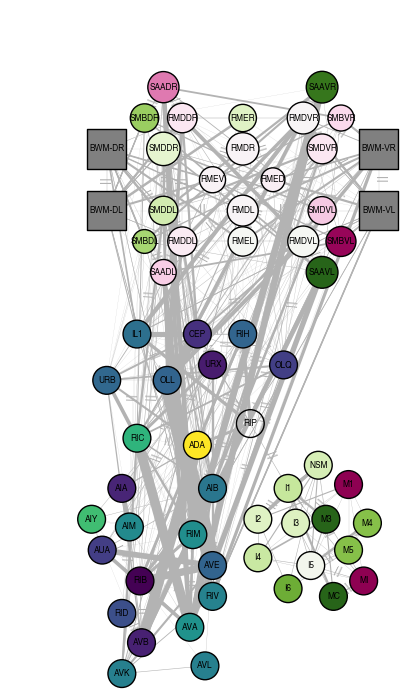

In [44]:
let
    ### color map
    # head
    cmax = 1
    cmin = 0
    cmap = ColorMap("PiYG")
    vmin, vmax = -0.25,0.25
    
    # pump
    cmaxp = 1
    cminp = 0
    cmapp = ColorMap("PiYG")
    vminp, vmaxp = -0.25,0.25

    # ewma
    cmax_ewma = 1
    cmin_ewma = 0
    cmap_ewma = ColorMap("viridis")
    vmin_ewma, vmax_ewma = log10(3), log10(45)
    
    ### size
    size_max = default_node_size + 400
    size_min = default_node_size - 250
    
    slope_max = 4
    slope_min = -4
    
    ### graph
    g_head = py_nx.Graph(edge_layout="curved")
    for (k,v) = dict_node
        g_head.add_node(v["id"], pos=v["pos"], node_size=v["size"], node_label=k, node_type=v["node_type"], node_subtype=v["node_subtype"])
    end
    
    for synapse = list_synapses
        g_head.add_edge(synapse[1], synapse[2], weight=synapse[4], synapse_type=synapse[3])
    end
    
    node_pos = py_nx.get_node_attributes(g_head, "pos")
    node_size = [dict_node[id_to_node_label[i]]["size"] for i = 1:length(id_to_node_label)]
    node_label = py_nx.get_node_attributes(g_head,"node_label")
    
    dict_pos_node_neuron = Dict()
    dict_label_node_neuron = Dict()
    list_node_color = []
    list_node_size = []
    list_node_edgecolors = []
    for i = 1:length(g_head.nodes)
        node_ = g_head.nodes.get(i)
        if node_["node_type"] == "neuron"
            dict_pos_node_neuron[i] = node_["pos"]
            node_label_ = node_["node_label"]
            dict_label_node_neuron[i] = node_label_
    
            if node_["node_subtype"] == "head"
                # color
                x_ = dict_dorsal_rev[node_label_]
                x_ = clamp(x_, vmin, vmax)
                x_ = (cmax - cmin) * (x_ - vmin) / (vmax - vmin) + cmin
                push!(list_node_color, cmap(x_))

                # size
                x_ = - dict_rev[node_label_]
                x_ = clamp(x_, slope_min, slope_max)
                x_ = (size_max - size_min) * (x_ - slope_min) / (slope_max - slope_min) + size_min
                push!(list_node_size, x_)
                push!(list_node_edgecolors, (0,0,0,1))
            elseif node_["node_subtype"] == "pharyngeal"
                # color
                x_ = dict_pumpingness[node_label_]
                x_ = isnan(x_) ? 0. : x_
                x_ = clamp(x_, vmin, vmax)
                x_ = (cmaxp - cminp) * (x_ - vminp) / (vmaxp - vminp) + cminp
                push!(list_node_color, cmapp(x_))

                # size
                push!(list_node_size, default_node_size)
                push!(list_node_edgecolors, (0,0,0,1))
            else
                # push!(list_node_color, (1,1,1,1))
                # color
                x_ = dict_τ[node_label_]
                x_ = log10(x_)
                x_ = clamp(x_, vmin_ewma, vmax_ewma)
                x_ = (cmax_ewma - cmin_ewma) * (x_ - vmin_ewma) / (vmax_ewma - vmin_ewma) + cmin_ewma
                push!(list_node_color, cmap_ewma(x_))


                push!(list_node_size, default_node_size)
                push!(list_node_edgecolors, (0,0,0,1))
            end
        else 
            push!(list_node_color, zeros(4))
            push!(list_node_size, default_node_size)
            push!(list_node_edgecolors, zeros(4))
        end
    end
    
    figure(figsize=(4.2,7))
    #### nodes
    py_nx.draw_networkx_nodes(g_head, node_pos, node_size=list_node_size, node_color=list_node_color, edgecolors=list_node_edgecolors)
    py_nx.draw_networkx_labels(g_head, dict_pos_node_neuron, labels=dict_label_node_neuron,
        font_size=6, font_family="Helvetica", font_weight="normal")
    
    #### edges
    g_edges = g_head.edges
    list_chemical = [(u,v) for (u,v) = g_edges if g_edges.get((u,v))["synapse_type"] == "chemical"]
    list_electrical = [(u,v) for (u,v) = g_edges if g_edges.get((u,v))["synapse_type"] == "electrical"]
    
    ## marking gap junction/electrical synapse with ||
    dict_edge_label = Dict()
    for (u,v) = g_edges
        if g_edges.get((u,v))["synapse_type"] == "electrical"
            dict_edge_label[(u,v)] = "||"
        end
    end
    py_nx.draw_networkx_edge_labels(g_head, node_pos, dict_edge_label,
        font_family="Helvetica", font_weight="normal", font_color=(0.7,0.7,0.7,1))

    ## electrical
    py_nx.draw_networkx_edges(g_head, node_pos, style="-", arrows=false, edge_color=(0.7,0.7,0.7,1),
        edgelist=[(u,v) for (u,v) = list_electrical],
        width=[g_edges.get((u,v))["weight"] / 10 for (u,v) = list_electrical])
    ## chemical
    py_nx.draw_networkx_edges(g_head, node_pos, arrows=false, edge_color=(0.7,0.7,0.7,1),
        edgelist=[(u,v) for (u,v) = list_chemical],
        width=[g_edges.get((u,v))["weight"] / 10 for (u,v) = list_chemical])

    #### node - muscle group
    dict_pos_node_neuron = Dict()
    dict_label_node_neuron = Dict()
    list_node_color = []
    list_node_size = []
    list_node_edgecolors = []
    list_node = []
    for i = 1:length(g_head.nodes)
        node_ = g_head.nodes.get(i)
        if node_["node_type"] == "muscle_group"
            push!(list_node, i)
            dict_pos_node_neuron[i] = node_["pos"]
            node_label_ = node_["node_label"]
            dict_label_node_neuron[i] = node_label_
            
            push!(list_node_color, (0.5,0.5,0.5,1))
            push!(list_node_size, 2 * default_node_size)
            push!(list_node_edgecolors, (0,0,0,1))
        end
    end
    py_nx.draw_networkx_nodes(g_head, dict_pos_node_neuron, nodelist=list_node,
        node_size=list_node_size, node_color=list_node_color,
        edgecolors=list_node_edgecolors, node_shape="s")
    py_nx.draw_networkx_labels(g_head, dict_pos_node_neuron, labels=dict_label_node_neuron,
        font_size=6, font_family="arial", font_weight="normal")

    #### other image settings
    axis("off")
    ylim(-11-22,11)
    xlim(-11-4.4,11)
    tight_layout()
    path_fig = joinpath(path_fig_root, "neuropal head rev and others")
    savefig(path_fig * ".pdf")    
    savefig(path_fig * ".png", dpi=300)
end